In [1]:
%load_ext autoreload
%autoreload 2

In [5]:
import sys
sys.path.append('../')
from quantum_DP import *
import itertools as it
from more_itertools import chunked

def callback(pbar, res):
    pbar.set_postfix(n=len(res), mean=np.round(np.mean(res, axis=0), 2))
    
def grouping(rho_pos, rho_neg, k):
    return (
        np.stack([cum_kron(rhos) for rhos in chunked(rho_pos, k)]),
        np.stack([cum_kron(rhos) for rhos in chunked(rho_neg, k)])
    )

## Figure 1

Comparison of probability of success for varying $\gamma$ in the case of identical copies, as a function of the number of available systems. 
Based on thecomputational results, we observe that as the depolarizing parameter increases, the probability of success levels off for large $N$.

In [190]:
num_trials = 1000
N_list, g_list = list(range(1, 13)), [0.01, 0.05, 0.1, 0.3]
param_grid = [('N', N_list), ('g', g_list)]
em = ExperimentManager('figure1.pickle', param_grid, num_trials)

# Precompute all the pure states
pure_state = [generate_rhos(max(N_list), identical=True, g=0, dim=2) for _ in range(num_trials)]
rho_pool = {
    g: [((1 - g) * rp + g / 2 * np.eye(2), (1 - g) * rn + g / 2 * np.eye(2)) for rp, rn in pure_state]
    for g in g_list
}
rho_iter = {g: it.cycle(rhos) for g, rhos in rho_pool.items()}

def simul_func(N, g):
    q, Qp = 1/2, 100
    use_CUDA = False
    device, cache = 'cuda:0' if use_CUDA else 'cpu', not use_CUDA
    rho_pos, rho_neg = next(rho_iter[g])
    rho_pos, rho_neg = rho_pos[:N], rho_neg[:N]

    kwargs = {
        'N': N, 'rho_pos': rho_pos, 'rho_neg': rho_neg, 'interp_mode': 'linear',
        'Qp': Qp, 'device': device, 'cache': cache
    }

    Asp = Locally_Greedy_ParamSpace(N, rho_pos, rho_neg, Qp, device)
    LG_QDP = Quantum_DP(**kwargs, param_space=Asp)
    prob_succ_LG = LG_QDP.root.prob_success(q)
    return prob_succ_LG
    
em.run(simul_func, callback)

VBox()

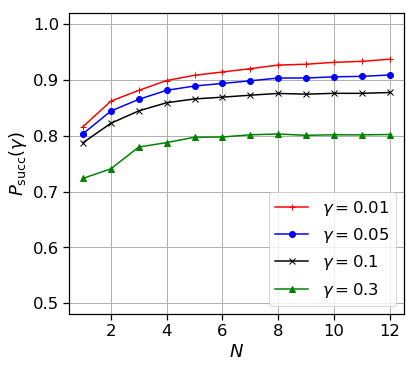

In [191]:
fig1_data = em.export_xarray(lambda x: x[0]).mean(axis=-1)
plt.axes().set_aspect(20)
plt.gcf().set_size_inches(6, 6)
plt.plot(N_list, fig1_data.sel(g=0.01), 'r+-', label=r'$\gamma=0.01$')
plt.plot(N_list, fig1_data.sel(g=0.05), 'bo-', label=r'$\gamma=0.05$')
plt.plot(N_list, fig1_data.sel(g=0.1), 'kx-', label=r'$\gamma=0.1$')
plt.plot(N_list, fig1_data.sel(g=0.3), 'g^-', label=r'$\gamma=0.3$')
plt.xlabel(r'$N$')
plt.xlim([0.5, 12.5])
plt.xticks([2, 4, 6, 8, 10, 12])
plt.ylabel(r'$P_{\mathrm{succ}}(\gamma)$')
plt.ylim([0.48, 1.02])
plt.legend(loc=4)
plt.grid()

## Figure 2

Comparison of probability of success for varying $\gamma$ in the distinct subsystems scenario, as a function of the number of available systems, $N$.

In [202]:
num_trials = 1000
N_list, g_list = list(range(1, 13)), [0.01, 0.05, 0.1, 0.3]
param_grid = [('N', N_list), ('g', g_list)]
em = ExperimentManager('figure2.pickle', param_grid, num_trials)

# Precompute all the pure states
pure_state = [generate_rhos(max(N_list), identical=False, g=0, dim=2) for _ in range(num_trials)]
rho_pool = {
    g: [((1 - g) * rp + g / 2 * np.eye(2), (1 - g) * rn + g / 2 * np.eye(2)) for rp, rn in pure_state]
    for g in g_list
}
rho_iter = {g: it.cycle(rhos) for g, rhos in rho_pool.items()}

def simul_func(N, g):
    q, Qp = 1/2, 100
    use_CUDA = False
    device, cache = 'cuda:0' if use_CUDA else 'cpu', not use_CUDA
    rho_pos, rho_neg = next(rho_iter[g])
    rho_pos, rho_neg = rho_pos[:N], rho_neg[:N]

    kwargs = {
        'N': N, 'rho_pos': rho_pos, 'rho_neg': rho_neg, 'interp_mode': 'linear',
        'Qp': Qp, 'device': device, 'cache': cache
    }

    Asp = Locally_Greedy_ParamSpace(N, rho_pos, rho_neg, Qp, device)
    LG_QDP = Quantum_DP(**kwargs, param_space=Asp)
    prob_succ_LG = LG_QDP.root.prob_success(q)
    return prob_succ_LG

em.run(simul_func, callback)

VBox()

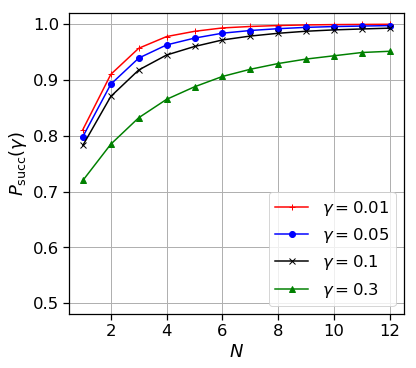

In [203]:
fig2_data = em.export_xarray(lambda x: x[0]).mean(axis=-1)
plt.axes().set_aspect(20)
plt.gcf().set_size_inches(6, 6)
plt.plot(N_list, fig2_data.sel(g=0.01), 'r+-', label=r'$\gamma=0.01$')
plt.plot(N_list, fig2_data.sel(g=0.05), 'bo-', label=r'$\gamma=0.05$')
plt.plot(N_list, fig2_data.sel(g=0.1), 'kx-', label=r'$\gamma=0.1$')
plt.plot(N_list, fig2_data.sel(g=0.3), 'g^-', label=r'$\gamma=0.3$')
plt.xlabel(r'$N$')
plt.xlim([0.5, 12.5])
plt.xticks([2, 4, 6, 8, 10, 12])
plt.ylabel(r'$P_{\mathrm{succ}}(\gamma)$')
plt.ylim([0.48, 1.02])
plt.legend(loc=4)
plt.grid()

## Figure 3

Comparison of probability of success as a function of thenumber of available systems, $N$, for depolarizing parameter $\gamma = 0.3$.

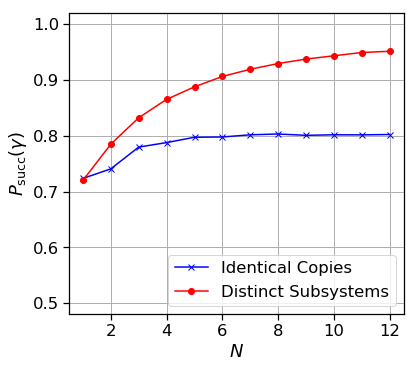

In [204]:
plt.axes().set_aspect(20)
plt.gcf().set_size_inches(6, 6)
plt.plot(N_list, fig1_data.sel(g=0.3), 'bx-', label='Identical Copies')
plt.plot(N_list, fig2_data.sel(g=0.3), 'ro-', label='Distinct Subsystems')
plt.xlabel(r'$N$')
plt.xlim([0.5, 12.5])
plt.xticks([2, 4, 6, 8, 10, 12])
plt.ylabel(r'$P_{\mathrm{succ}}(\gamma)$')
plt.ylim([0.48, 1.02])
plt.legend(loc=4)
plt.grid()

## Figure 4

Probability of success for identical copies as a function of $\gamma$ and number of subsystems measured simultaneously , $m$. Here $N = 6$

In [192]:
num_trials = 1000
m_list = [x for x in range(1, 7) if 6 % x == 0]
g_list = [0, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.7, 1]
param_grid = [('m', m_list), ('g', g_list)]
em = ExperimentManager('figure4.pickle', param_grid, num_trials)

# Precompute all the pure states
pure_state = [generate_rhos(max(m_list), identical=True, g=0, dim=2) for _ in range(num_trials)]
rho_pool = {
    g: [((1 - g) * rp + g / 2 * np.eye(2), (1 - g) * rn + g / 2 * np.eye(2)) for rp, rn in pure_state]
    for g in g_list
}
rho_iter = {g: it.cycle(rhos) for g, rhos in rho_pool.items()}

def simul_func(m, g):
    if m != 6:
        N, q, Qp = 6//m, 1/2, 100
        use_CUDA = False
        device, cache = 'cuda:0' if use_CUDA else 'cpu', not use_CUDA
        cache = True
        rho_pos, rho_neg = next(rho_iter[g])
        rho_pos, rho_neg = grouping(rho_pos, rho_neg, m)

        kwargs = {
            'N': N, 'rho_pos': rho_pos, 'rho_neg': rho_neg, 'interp_mode': 'linear',
            'Qp': Qp, 'device': device, 'cache': cache
        }

        Asp = Locally_Greedy_ParamSpace(N, rho_pos, rho_neg, Qp, device)
        LG_QDP = Quantum_DP(**kwargs, param_space=Asp)
        prob_succ_LG = LG_QDP.root.prob_success(q)
        return prob_succ_LG
    else:
        q = 1/2
        rho_pos, rho_neg = next(rho_iter[g])
        prob_succ_H = helstrom(q, rho_pos, rho_neg)
        return prob_succ_H[0]

em.run(simul_func, callback)

VBox()

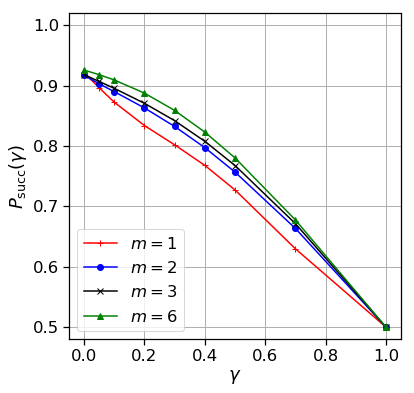

In [193]:
fig4_data = em.export_xarray(lambda x: x).mean(axis=-1)
plt.axes().set_aspect(2)
plt.gcf().set_size_inches(6, 6)
plt.plot(g_list, fig4_data.sel(m=1), 'r+-', label=r'$m=1$')
plt.plot(g_list, fig4_data.sel(m=2), 'bo-', label=r'$m=2$')
plt.plot(g_list, fig4_data.sel(m=3), 'kx-', label=r'$m=3$')
plt.plot(g_list, fig4_data.sel(m=6), 'g^-', label=r'$m=6$')
plt.xlabel(r'$\gamma$')
plt.ylabel(r'$P_{\mathrm{succ}}(\gamma)$')
plt.ylim([0.48, 1.02])
plt.legend(loc=3)
plt.grid()

## Figure 5

Probability of success for distinct subsystems as a function of $\gamma$ and number of subsystems measured simultaneously , $m$. Here $N = 6$

In [194]:
num_trials = 1000
m_list = [x for x in range(1, 7) if 6 % x == 0]
g_list = [0, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.7, 1]
param_grid = [('m', m_list), ('g', g_list)]
em = ExperimentManager('figure5.pickle', param_grid, num_trials)

# Precompute all the pure states
pure_state = [generate_rhos(max(m_list), identical=True, g=0, dim=2) for _ in range(num_trials)]
rho_pool = {
    g: [((1 - g) * rp + g / 2 * np.eye(2), (1 - g) * rn + g / 2 * np.eye(2)) for rp, rn in pure_state]
    for g in g_list
}
rho_iter = {g: it.cycle(rhos) for g, rhos in rho_pool.items()}

def simul_func(m, g):
    if m != 6:
        N, q, Qp = 6//m, 1/2, 100
        use_CUDA = False
        device, cache = 'cuda:0' if use_CUDA else 'cpu', not use_CUDA
        cache = True
        rho_pos, rho_neg = next(rho_iter[g])
        rho_pos, rho_neg = grouping(rho_pos, rho_neg, m)

        kwargs = {
            'N': N, 'rho_pos': rho_pos, 'rho_neg': rho_neg, 'interp_mode': 'linear',
            'Qp': Qp, 'device': device, 'cache': cache
        }

        Asp = Locally_Greedy_ParamSpace(N, rho_pos, rho_neg, Qp, device)
        LG_QDP = Quantum_DP(**kwargs, param_space=Asp)
        prob_succ_LG = LG_QDP.root.prob_success(q)
        return prob_succ_LG[0]
    else:
        q = 1/2
        rho_pos, rho_neg = next(rho_iter[g])
        prob_succ_H = helstrom(q, rho_pos, rho_neg)
        return prob_succ_H[0]

em.run(simul_func, callback)

VBox()

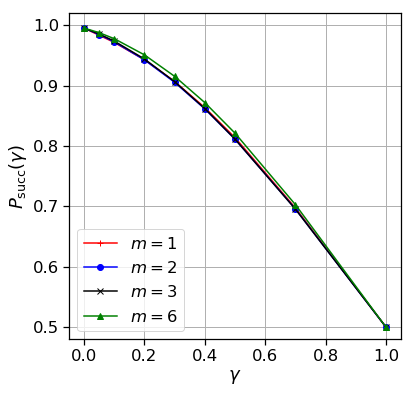

In [195]:
fig5_data = em.export_xarray(lambda x: x).mean(axis=-1)
plt.axes().set_aspect(2)
plt.gcf().set_size_inches(6, 6)
plt.plot(g_list, fig5_data.sel(m=1), 'r+-', label=r'$m=1$')
plt.plot(g_list, fig5_data.sel(m=2), 'bo-', label=r'$m=2$')
plt.plot(g_list, fig5_data.sel(m=3), 'kx-', label=r'$m=3$')
plt.plot(g_list, fig5_data.sel(m=6), 'g^-', label=r'$m=6$')
plt.xlabel(r'$\gamma$')
plt.ylabel(r'$P_{\mathrm{succ}}(\gamma)$')
plt.ylim([0.48, 1.02])
plt.legend(loc=3)
plt.grid()

## Figure 6

Probability of success for the special case $\gamma=0.3$ when the subsystems are not necessarily copies. 
Here $N=6$. 
This clearly illustrates the initial dip in probability of success with increasing $m$.

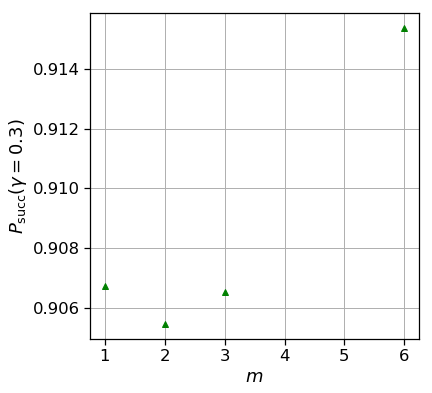

In [196]:
fig4_data = em.export_xarray(lambda x: x).mean(axis=-1)
plt.axes().set_aspect(500)
plt.gcf().set_size_inches(6, 6)
plt.plot(m_list, fig5_data.sel(g=0.3), 'g^')
plt.xlabel(r'$m$')
plt.ylabel(r'$P_{\mathrm{succ}}(\gamma=0.3)$')
plt.grid()

## Figure 7

Comparison of probability of $P_{\mathrm{best}}(3, \gamma)$ and $P_{\mathrm{worst}}(3, \gamma)$ as a function of the depolarising parameter $\gamma$ for $N=3$. 
Although $P_{\mathrm{best}}(3, \gamma) \ne P_{\mathrm{worst}}(3, \gamma)$, the relative difference is small.

In [172]:
num_trials = 1000
g_list = [0, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.7, 1]
N_list = [3, 4, 5, 6, 7]
param_grid = [('N', N_list), ('g', g_list)]
em = ExperimentManager('figure7.pickle', param_grid, num_trials)

# Precompute all the pure states
pure_state = [generate_rhos(max(N_list), identical=False, g=0, dim=2) for _ in range(num_trials)]
rho_pool = {
    g: [((1 - g) * rp + g / 2 * np.eye(2), (1 - g) * rn + g / 2 * np.eye(2)) for rp, rn in pure_state]
    for g in g_list
}
rho_iter = {g: it.cycle(rhos) for g, rhos in rho_pool.items()}

def simul_func(N, g):
    q, Qp = 1/2, 100
    use_CUDA = False
    device, cache = 'cuda:0' if use_CUDA else 'cpu', not use_CUDA
    rho_pos, rho_neg = next(rho_iter[g])
    rho_pos, rho_neg = rho_pos[:N], rho_neg[:N]

    kwargs = {
        'N': N, 'rho_pos': rho_pos, 'rho_neg': rho_neg, 'interp_mode': 'linear',
        'Qp': Qp, 'device': device, 'cache': cache
    }

    Asp = Qubit_Proj_ParamSpace(Qphi=128, device=device)
    Qb_QDP = Quantum_DP(**kwargs, param_space=Asp)
    prob_succ_B = Qb_QDP.root.prob_success(q)
    
    return prob_succ_B

def callback(pbar, res):
    pbar.set_postfix(n=len(res), mean=np.round(np.mean(res, axis=0), 2))
    
em.run(simul_func, callback)

VBox()

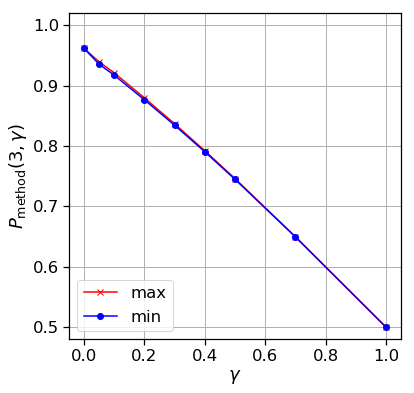

In [173]:
fig7_best = em.export_xarray(lambda x: x[0]).mean(axis=-1)
fig7_worst = em.export_xarray(lambda x: x[-1]).mean(axis=-1)

plt.axes().set_aspect(2)
plt.gcf().set_size_inches(6, 6)
plt.plot(g_list, fig7_best.sel(N=3), 'rx-', label='max')
plt.plot(g_list, fig7_worst.sel(N=3), 'bo-', label='min')
plt.xlabel(r'$\gamma$')
plt.ylabel(r'$P_{\mathrm{method}}(3, \gamma)$')
plt.ylim([0.48, 1.02])
plt.legend(loc=3)
plt.grid()

## Figure 8

Comparison of difference in maximum and minimum probability of success, $P_{\mathrm{diff}}(N, \gamma)$, as a function of the depolarizing parameter $\gamma$ over $200$ trials for $N = 3,4,5,6,7$.

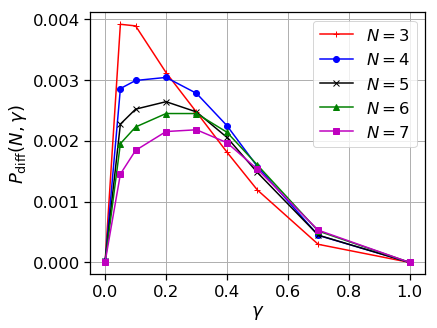

In [174]:
fig7_diff = fig7_best - fig7_worst
plt.axes().set_aspect(200)
plt.gcf().set_size_inches(6, 6)
plt.plot(g_list, fig7_diff.sel(N=3), 'r+-', label=r'$N=3$')
plt.plot(g_list, fig7_diff.sel(N=4), 'bo-', label=r'$N=4$')
plt.plot(g_list, fig7_diff.sel(N=5), 'kx-', label=r'$N=5$')
plt.plot(g_list, fig7_diff.sel(N=6), 'g^-', label=r'$N=6$')
plt.plot(g_list, fig7_diff.sel(N=7), 'ms-', label=r'$N=7$')
plt.xlabel(r'$\gamma$')
plt.ylabel(r'$P_{\mathrm{diff}}(N,\gamma)$')
plt.legend(loc=1)
plt.grid()

## Figure 9

The average probability of success for the best and worst ordering using both ternary and binary projective measurements for qutrit product states when $N=3$. Results are averaged over $100$ trials

In [186]:
num_trials = 1000
g_list = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6]
N_list = [3]
param_grid = [('N', N_list), ('g', g_list)]
em = ExperimentManager('figure9.pickle', param_grid, num_trials)

# Precompute all the pure states
pure_state = [generate_rhos(max(N_list), identical=False, g=0, dim=3) for _ in range(num_trials)]
rho_pool = {
    g: [((1 - g) * rp + g / 3 * np.eye(3), (1 - g) * rn + g / 3 * np.eye(3)) for rp, rn in pure_state]
    for g in g_list
}
rho_iter = {g: it.cycle(rhos) for g, rhos in rho_pool.items()}

def simul_func(N, g):
    q, Qp = 1/2, 100
    use_CUDA = True
    device, cache = 'cuda:0' if use_CUDA else 'cpu', not use_CUDA
    rho_pos, rho_neg = next(rho_iter[g])
    rho_pos, rho_neg = rho_pos[:N], rho_neg[:N]

    kwargs = {
        'N': N, 'rho_pos': rho_pos, 'rho_neg': rho_neg, 'interp_mode': 'linear',
        'Qp': Qp, 'device': device, 'cache': cache
    }

    Asp3 = Qutrit_Proj_ParamSpace(d=[2, 2, 2], Q=32, mode='ternary', device=device)
    QQDP3 = Quantum_DP(**kwargs, param_space=Asp3)
    prob_succ_T = QQDP3.root.prob_success(q)

    Asp2 = Qutrit_Proj_ParamSpace(d=[2, 2, 2], Q=32, mode='binary', device=device)
    QQDP2 = Quantum_DP(**kwargs, param_space=Asp2)
    prob_succ_B = QQDP2.root.prob_success(q)
    
    return np.concatenate([prob_succ_T, prob_succ_B])

def callback(pbar, res):
    pbar.set_postfix(n=len(res), mean=np.round(np.mean(res, axis=0), 2))
    
em.run(simul_func, callback)

VBox()

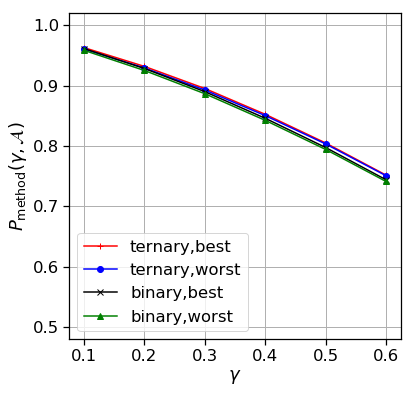

In [187]:
fig9_ternary_best = em.export_xarray(lambda x: x[0]).mean(axis=-1)
fig9_ternary_worst = em.export_xarray(lambda x: x[1]).mean(axis=-1)
fig9_binary_best = em.export_xarray(lambda x: x[2]).mean(axis=-1)
fig9_binary_worst = em.export_xarray(lambda x: x[3]).mean(axis=-1)

plt.axes().set_aspect(1)
plt.gcf().set_size_inches(6, 6)
plt.plot(g_list, fig9_ternary_best.sel(N=3), 'r+-', label='ternary,best')
plt.plot(g_list, fig9_ternary_worst.sel(N=3), 'bo-', label='ternary,worst')
plt.plot(g_list, fig9_binary_best.sel(N=3), 'kx-', label='binary,best')
plt.plot(g_list, fig9_binary_worst.sel(N=3), 'g^-', label='binary,worst')
plt.xlabel(r'$\gamma$')
plt.ylabel(r'$P_{\mathrm{method}}(\gamma,\mathcal{A})$')
plt.ylim([0.48, 1.02])
plt.legend(loc=3)
plt.grid()

## Figure 10

Difference in average success probability for the various methods, namely, $P_{d, \mathrm{method}}(\gamma, \mathcal{A})$ as a function of $\gamma$ when $N=3$. Results are averaged over $100$ trials.

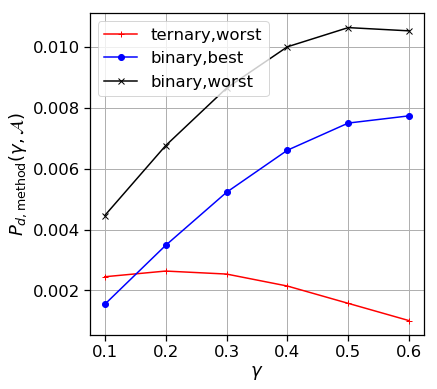

In [189]:
plt.axes().set_aspect(50)
plt.gcf().set_size_inches(6, 6)
plt.plot(g_list, (fig9_ternary_best - fig9_ternary_worst).sel(N=3), 'r+-', label='ternary,worst')
plt.plot(g_list, (fig9_ternary_best - fig9_binary_best).sel(N=3), 'bo-', label='binary,best')
plt.plot(g_list, (fig9_ternary_best - fig9_binary_worst).sel(N=3), 'kx-', label='binary,worst')
plt.xlabel(r'$\gamma$')
plt.ylabel(r'$P_{d, \mathrm{method}}(\gamma,\mathcal{A})$')
plt.legend(loc=2)
plt.grid()